In [329]:
# Standard library imports
import os
import sys
import re
import warnings
import random
import hashlib

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing and model selection tools
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV,
                                     RandomizedSearchCV, TimeSeriesSplit)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# Metrics and scoring
from sklearn.metrics import (balanced_accuracy_score, classification_report, f1_score,
                             make_scorer, confusion_matrix, precision_score, accuracy_score)

# Machine learning models
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier,
                              AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Neural networks
from sklearn.neural_network import MLPClassifier

# selection
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest
from sklearn.base import clone

# Advanced models and ensemble techniques
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Iputing missing values
from sklearn.impute import SimpleImputer

# Handling imbalanced datasets
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Encoding and feature selection
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform

# Model persistence
from joblib import dump, load

# Miscellaneous settings
warnings.filterwarnings('ignore')

In [330]:
content = "allcomps_3s"

In [331]:
# Load the processed data csv into a DataFrame
df = pd.read_csv(f'data/processed/processed_data_{content}.csv')

In [332]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [333]:
# Parse the date_temp column, which is in YYYYMMDD format, into a datetime object, and store in a new column 'date_temporary'
df['date_temporary'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [334]:
df.columns

Index(['Div', 'Season', 'Date', 'Time', 'DayOTW', 'Team_ID', 'Opp_ID', 'FTR',
       'team_elo', 'opp_elo', 'team_xg', 'opp_xg', 'team_hist_vs',
       'opp_hist_vs', 'team_points', 'opp_points', 'elo_diff', 'xg_diff',
       'points_diff', 'form_diff', 'team_form', 'opp_form',
       'team_avg_goals_for', 'team_avg_goals_against', 'opp_avg_goals_for',
       'opp_avg_goals_against', 'team_shots', 'opp_shots', 'team_shots_target',
       'opp_shots_target', 'AvgH', 'AvgD', 'AvgA', 'date_temporary'],
      dtype='object')

In [335]:
# Drop columns
df.drop(columns=[ 




#'AvgH', 'AvgD', 'AvgA',

#'Season', 'Div', 'DayOTW',

#'team_xg', 'opp_xg', 
#'team_hist_vs', 'opp_hist_vs', 

#'team_points', 'opp_points', 
#'team_form', 'opp_form',

#'team_shots', 'opp_shots', 
#'team_shots_target', 'opp_shots_target',

#'team_avg_goals_against', 'opp_avg_goals_against',

 ], inplace=True)

### Date settings

In [336]:
import pandas as pd

# Get the current date dynamically
date_today = pd.Timestamp.now().normalize()  # .normalize() sets the time to 00:00:00

# Declare a date by setting day, month, and year
date_specific = pd.Timestamp(year=2024, month=5, day=1)

# Calculate the date 2 weeks ago from the current date
date_delta = date_specific - pd.DateOffset(days=14)

# Specific start date
#date_start = date_specific - pd.DateOffset(days=1000)

# No filter, all data
date_start = pd.Timestamp(year=2022, month=7, day=1)

In [337]:
# Delete all rows where the date_temporary column is older than date_start
df = df[df['date_temporary'] >= date_start]

In [338]:
# define df_validationset as all the rows in df where the date_temporary column is greater than date_delta
df_validationset = df[df['date_temporary'] > date_delta]

# define df as all the rows in df where the date_temporary column is less than or equal to date_delta
df = df[df['date_temporary'] <= date_delta]

In [339]:
len(df), len(df_validationset)

(12935, 529)

In [340]:
# Drop the date_temporary column
df.drop(columns=['date_temporary'], inplace=True)
df_validationset.drop(columns=['date_temporary'], inplace=True)

In [341]:
import ast
import pandas as pd

teams_dict = {}
comps_dict = {}

with open(f'data/teams_dict_{content}.txt', 'r') as file:
    data = file.read()
    teams_dict = ast.literal_eval(data)

with open(f'data/comps_dict_{content}.txt', 'r') as file:
    data = file.read()
    comps_dict = ast.literal_eval(data)

In [342]:
# Sort the df and df_validationset DataFrames by the 'Date', 'Div', 'Time' columns
df.sort_values(['Date', 'Div', 'Time'], inplace=True)
df_validationset.sort_values(['Date', 'Div', 'Time'], inplace=True)

# Set the 'Date' and 'FTR' column as the index
df.set_index(['Date'], inplace=True)
df_validationset.set_index(['Date'], inplace=True)

In [343]:
#import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into X and y
X = df.drop(['FTR', 'AvgH', 'AvgD', 'AvgA'], axis=1) 
y = df['FTR']

X.columns = [re.sub(r'[<]', '_st_', str(col)) for col in X.columns]
X.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameters

In [344]:
param_dist = {

    'xgb__clf__max_depth': [1,2,3, 4, 6],
    'xgb__clf__learning_rate': [0.05, 0.1, 0.15],
    'xgb__clf__reg_lambda': [0.01, 0.1], 
    'xgb__clf__alpha': [0, 0.5, 1],  
    'xgb__clf__colsample_bytree': [0.7, 0.9],
    'xgb__clf__subsample': [0.75, 0.85],
    'xgb__clf__n_estimators': [1, 5, 10],

    'rf__clf__max_depth': [1, 2],
    'rf__clf__min_samples_split': [3, 6],
    'rf__clf__min_samples_leaf': [1, 3],
    'rf__clf__n_estimators': [1, 5, 10],
    'rf__clf__max_features': ['sqrt', 'log2'],

    'lr__clf__C': [0.1, 1],
    'lr__clf__penalty': ['l1', 'l2', 'elasticnet'], 
    'lr__clf__solver': ['saga'], 
    'lr__clf__l1_ratio': [0.5], 
    'lr__clf__class_weight': ['balanced'],

    'gb__clf__learning_rate': [0.01, 0.1, 0.15],
    'gb__clf__n_estimators': [1, 5, 10],
    'gb__clf__max_depth': [3, 5 , 7],
    'gb__clf__min_samples_split': [2, 5],
    'gb__clf__min_samples_leaf': [1, 2],
    
}


In [345]:
def generate_sliding_windows_by_div(X):
    grouped = X.groupby('Div')  # Group by 'Div' only
    windows = []

    for div, group in grouped:
        indices = group.index.tolist()  # Get indices of each group
        n_samples = len(indices)

        if n_samples < 2:
            print(f"Skipping division {div} with insufficient samples: {n_samples}")
            continue

        # Using 80% of data for training and the rest for testing
        split_point = int(n_samples * 0.8)
        train_indices = indices[:split_point]
        test_indices = indices[split_point:]

        if train_indices and test_indices:  # Ensure both are non-empty
            windows.append((train_indices, test_indices))

    return windows


In [346]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

def xgb_early_stopping_score(estimator, X, y_true, sample_weight=None):
    """
    Custom scorer that uses early stopping.
    """
    # Predict using the already fitted estimator
    y_pred = estimator.predict(X)
    
    # Return the F1 score or any other relevant metric
    return f1_score(y_true, y_pred, pos_label=1)


In [347]:
def create_pipeline(base_estimator, fts=14, random_state=42):
    pipeline = ImbPipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        #('smote', SMOTE(random_state=random_state, k_neighbors=2)),
        #('select', SelectKBest(chi2, k=fts)),
        ('clf', clone(base_estimator))
    ])
    return pipeline

In [348]:
classifiers = {
    'xgb': XGBClassifier(random_state=42, verbose=0),
    'gb': GradientBoostingClassifier(random_state=42, verbose=0),
    'lr': LogisticRegression(random_state=42, verbose=0, multi_class='ovr'),
    'rf': RandomForestClassifier(random_state=42, verbose=0),
    'ada': AdaBoostClassifier(random_state=42),
    'lgbm': LGBMClassifier(random_state=42, force_col_wise='true', verbose=0),
    'MLP': MLPClassifier(random_state=42, verbose=0)
}

# Generate pipelines for each classifier
pipelines = {name: create_pipeline(clf) for name, clf in classifiers.items()}

# Create the ensemble classifier
ensemble_clf = VotingClassifier(
    estimators=[(name, pipeline) for name, pipeline in pipelines.items()],
    voting='soft'
)

In [349]:
scoring = {
    'f1_score': make_scorer(f1_score, average='macro'),  
    'accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
}

In [350]:
def enhanced_rolling_window_ensemble(X, y, window_size, step_size):
    num_samples = len(X)
    start_index = 0
    # Initialize with an empty 'y' column
    additional_training_data = pd.DataFrame(columns=['y'])

    counter = 1

    while start_index + window_size < num_samples:
        end_index = start_index + window_size
        
        # Drop the 'y' column safely with errors='ignore' to handle cases where it might be absent
        X_train = pd.concat([X.iloc[start_index:end_index], additional_training_data.drop(columns=['y'], errors='ignore')])
        # Concatenate y-values safely
        if not additional_training_data.empty:     

            y_train = pd.concat([y.iloc[start_index:end_index], additional_training_data['y']])

            print(f"Additional data: {len(additional_training_data)}")
            print(f"train size: {len(y_train)}")
        else:
            y_train = y.iloc[start_index:end_index]
        
        X_test = X.iloc[end_index:end_index + step_size]
        y_test = y.iloc[end_index:end_index + step_size]  

        print()
        print(f"Iteration {counter}: Training on matches {start_index} to {end_index} of {num_samples}")   


        clf = RandomizedSearchCV(
            estimator=ensemble_clf,
            param_distributions=param_dist,
            n_iter=1,
            scoring=scoring,
            refit='f1_score', 
            cv=TimeSeriesSplit(n_splits=10),
            random_state=42,
            n_jobs=-1,
            verbose=0,
            error_score='raise'
        )

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        
        wrong_indices = y_test != y_pred
        wrong_data = X_test[wrong_indices].copy()
        wrong_data['y'] = y_test[wrong_indices]
        additional_training_data = wrong_data

        print("Accuracy:", accuracy_score(y_test, y_pred))

        start_index += step_size

        counter += 1
    
    return clf  


### Training

In [351]:
# Make the custom scorer
custom_scorer = make_scorer(xgb_early_stopping_score, greater_is_better=True, needs_proba=False, X=X, y_true=y)

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print(f"Number of rows: {len(X)} ") 

window_size = 2500  
step_size =  500
model = enhanced_rolling_window_ensemble(X, y, window_size, step_size)

Number of rows: 12935 

Iteration 1: Training on matches 0 to 2500 of 12935
Accuracy: 0.502
Additional data: 249
train size: 2749

Iteration 2: Training on matches 500 to 3000 of 12935
Accuracy: 0.568
Additional data: 216
train size: 2716

Iteration 3: Training on matches 1000 to 3500 of 12935
Accuracy: 0.604
Additional data: 198
train size: 2698

Iteration 4: Training on matches 1500 to 4000 of 12935
Accuracy: 0.596
Additional data: 202
train size: 2702

Iteration 5: Training on matches 2000 to 4500 of 12935
Accuracy: 0.574
Additional data: 213
train size: 2713

Iteration 6: Training on matches 2500 to 5000 of 12935
Accuracy: 0.564
Additional data: 218
train size: 2718

Iteration 7: Training on matches 3000 to 5500 of 12935
Accuracy: 0.544
Additional data: 228
train size: 2728

Iteration 8: Training on matches 3500 to 6000 of 12935
Accuracy: 0.618
Additional data: 191
train size: 2691

Iteration 9: Training on matches 4000 to 6500 of 12935
Accuracy: 0.574
Additional data: 213
train si

In [352]:
model

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   error_score='raise',
                   estimator=VotingClassifier(estimators=[('xgb',
                                                           Pipeline(steps=[('imputer',
                                                                            SimpleImputer()),
                                                                           ('target_encoder',
                                                                            TargetEncoder()),
                                                                           ('scaler',
                                                                            StandardScaler()),
                                                                           ('min_max_scaler',
                                                                            MinMaxScaler()),
                                                                           ('clf',
                                                                            XGBClassifier(base_score=None,
                                                                                          booster=None,
                                                                                          c...
                                        'xgb__clf__n_estimators': [1, 5, 10],
                                        'xgb__clf__reg_lambda': [0.01, 0.1],
                                        'xgb__clf__subsample': [0.75, 0.85]},
                   random_state=42, refit='f1_score',
                   scoring={'accuracy': make_scorer(balanced_accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict', average=macro),
                            'precision': make_scorer(precision_score, response_method='predict', average=macro)})

In [353]:
best_model = model.best_estimator_ 

In [354]:
# PRint a classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      1147
           1       0.45      0.26      0.33       666
           2       0.59      0.64      0.61       774

    accuracy                           0.60      2587
   macro avg       0.56      0.56      0.55      2587
weighted avg       0.58      0.60      0.58      2587



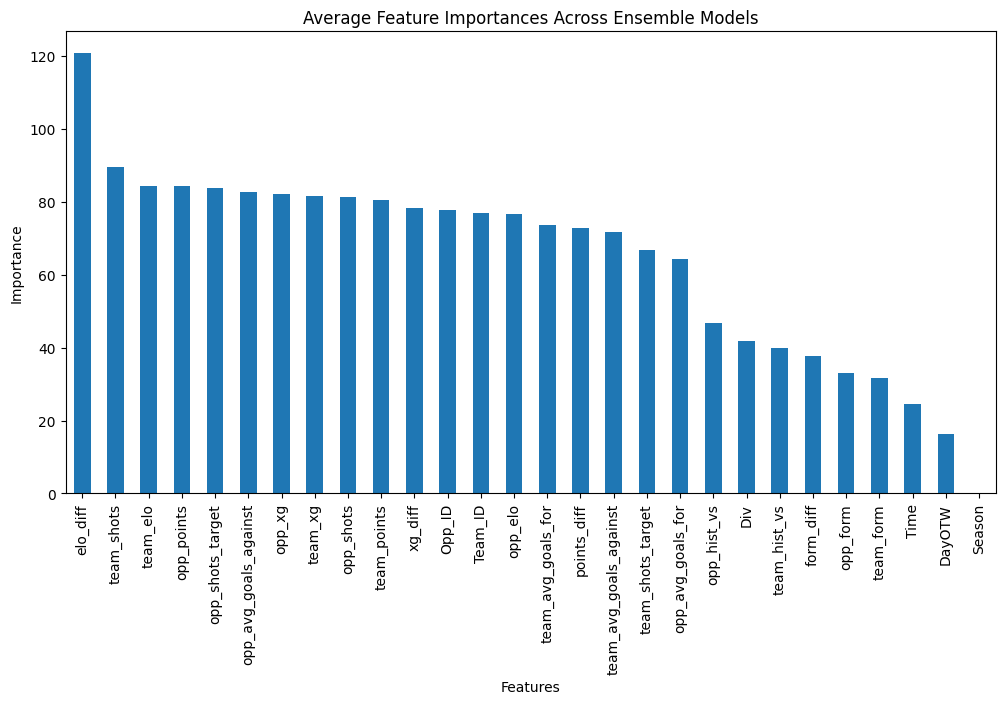

In [355]:
# Feature Importances

# Initialize a dictionary to store feature importances
feature_importances = {}

# Loop through each classifier in the ensemble
for clf_name, clf_pipeline in best_model.named_estimators_.items():
    if hasattr(clf_pipeline.named_steps['clf'], 'feature_importances_'):
        # Extract feature importances
        importances = clf_pipeline.named_steps['clf'].feature_importances_

        # Access feature names via the 'select' step in pipeline if available
        # Assuming feature selection might alter the features passed to the classifier
        if 'select' in clf_pipeline.named_steps:
            mask = clf_pipeline.named_steps['select'].get_support()  # Get the boolean mask
            feature_names = np.array(X.columns)[mask]
        else:
            feature_names = np.array(X.columns)

        # Combine feature names and their corresponding importance
        feature_importances[clf_name] = pd.Series(importances, index=feature_names)

# Now plot the feature importances
plt.figure(figsize=(12, 6))

avg_importances = pd.DataFrame(feature_importances).mean(axis=1).sort_values(ascending=False)

avg_importances.plot(kind='bar')
plt.title('Average Feature Importances Across Ensemble Models')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


In [356]:
df_val = df_validationset.copy()

# Calculate the predicted probabilities for the validation set
y_val_proba = best_model.predict_proba(df_val.drop(columns=['FTR', 'AvgH', 'AvgD', 'AvgA']))

In [357]:
len(df_val), len(y_val_proba)

(529, 529)

In [358]:
df_val['Prob1'] = y_val_proba[:, 0].round(3)
df_val['ProbX'] = y_val_proba[:, 1].round(3)
df_val['Prob2'] = y_val_proba[:, 2].round(3)

# Get the column index of the y_val_proba with the highest probability
df_val['Prediction'] = y_val_proba.argmax(axis=1)

# Map the prediction column to the actual result
df_val['Prediction'] = df_val['Prediction'].map({0: '1', 1: 'X', 2: '2'})

# Display all predictions
filtered_df_val = df_val.copy()

filtered_df_val.reset_index(inplace=True)

# Map the 'Team_ID' and 'Opp_ID' columns to the actual team names
index_to_team = {v: k for k, v in teams_dict.items()}
filtered_df_val['Team'] = filtered_df_val['Team_ID'].map(index_to_team)
filtered_df_val['Opponent'] = filtered_df_val['Opp_ID'].map(index_to_team)

# Map the 'Div' column to the actual competition name
index_to_comp = {v: k for k, v in comps_dict.items()}
filtered_df_val['Div'] = filtered_df_val['Div'].map(index_to_comp)

display_columns = [
    'Div', 
    
    'Date', 'Time', 'Team', 'Opponent', 
    
    'FTR',

    'team_points', 'opp_points',
    'team_form', 'opp_form',
    
    'Prediction', 
    
    'team_elo',     
    'opp_elo',  

    'team_xg', 'opp_xg',

    'Prob1', 'ProbX', 'Prob2',    
       
    'AvgH', 'AvgD', 'AvgA', 
]

In [359]:

output = filtered_df_val[display_columns]

output.sort_values(['Div', 'Date', 'Team'], inplace=True)

In [360]:
len(output)

529

In [361]:
def make_prediction(row):

    prob1 = row['Prob1']
    probX = row['ProbX']
    prob2 = row['Prob2']

    # Directly return '1' or '2' if their probabilities are greater than 0.6
    if prob1 > 0.65:
        return '1'
    if prob2 > 0.65:
        return '2'    

    # Define the expected value (probability * bookmaker's odds)
    # Calculate combined probabilities for '1X' and 'X2'
    prob1X = prob1 + probX
    probX2 = probX + prob2

    # Create a dictionary to compare probabilities with bet types
    bets = {
        '1': prob1,
        'X': probX,
        '2': prob2,
        '1X': prob1X,
        'X2': probX2
    }

    # Determine the best bet by finding the maximum probability
    best_bet = max(bets, key=bets.get)
    return best_bet


In [362]:
output['1X2'] = output.apply(make_prediction, axis=1)

In [363]:
def is_bet_correct(row):
    if row['FTR'] == 0:
        return row['1X2'] in ['1', '1X']
    elif row['FTR'] == 1:
        return row['1X2'] in ['1X', 'X', 'X2']
    elif row['FTR'] == 2:
        return row['1X2'] in ['X2', '2']
    return False

In [ ]:
if output['FTR'] is not None:
    output['Correct'] = output.apply(is_bet_correct, axis=1)
else:
    output['Correct'] = None

In [365]:
def bet_confidence(row):

    Prob1 = row['Prob1']
    ProbX = row['ProbX']
    Prob2 = row['Prob2']

    # parse the probabilities into floats
    Prob1 = float(Prob1)
    ProbX = float(ProbX)
    Prob2 = float(Prob2)

    conf = 0

    if row['1X2'] == '1':
        conf =  Prob1
    elif row['1X2'] == '1X':
        conf = Prob1 + ProbX
    elif row['1X2'] == 'X':
        conf = ProbX
    elif row['1X2'] == 'X2':
        conf = ProbX + Prob2
    elif row['1X2'] == '2':
        conf =  Prob2

    # round the confidence to 2 decimal places
    conf = round(conf, 2)

    return conf

In [366]:
output['Confidence'] = output.apply(bet_confidence, axis=1)

In [367]:
# Map the 'FTR' back to the actual result
output['FTR'] = output['FTR'].map({0: '1', 1: 'X', 2: '2'})

### Validation

In [368]:
values = ['1', 'X', '2']

# Filter the DataFrame based on the 'FTR' column and count the rows
total_rows = output[output['FTR'].isin(values)].shape[0]

# Display the total amount of predictions where the value is True
#total_correct = output['Correct'].sum()
total_correct = output[(output['FTR'].isin(values)) & (output['Correct'])].shape[0]

# Calculate the percentage of correct predictions
correct_percentage = (total_correct / total_rows) * 100

# Display the results
print(f"Total Rows: {total_rows}")
print(f"Total Correct Predictions: {total_correct}")
print(f"Percentage of Correct Predictions: {correct_percentage:.2f}%")

Total Rows: 384
Total Correct Predictions: 324
Percentage of Correct Predictions: 84.38%


In [369]:
# if AvgH exists
if 'AvgH' in output.columns:

    # Change the decimal sign to a point for AvgH, AvgD, and AvgA columns to avoid parsing issues
    output['AvgH'] = output['AvgH'].apply(lambda x: str(x).replace(',', '.'))
    output['AvgD'] = output['AvgD'].apply(lambda x: str(x).replace(',', '.'))
    output['AvgA'] = output['AvgA'].apply(lambda x: str(x).replace(',', '.'))

    # parse AvgH, AvgD, AvgA columns as float
    output['AvgH'] = output['AvgH'].astype(float)
    output['AvgD'] = output['AvgD'].astype(float)
    output['AvgA'] = output['AvgA'].astype(float)

    # parse team_xg, opp_xg, team_form, opp_form, team_points, opp_points as float and round to 3 decimal places
    output['team_xg'] = output['team_xg'].astype(float).round(3)
    output['opp_xg'] = output['opp_xg'].astype(float).round(3)
    output['team_form'] = output['team_form'].astype(float).round(3)
    output['opp_form'] = output['opp_form'].astype(float).round(3)
    output['team_points'] = output['team_points'].astype(float).round(3)
    output['opp_points'] = output['opp_points'].astype(float).round(3)

    # Change the decimal sign to a comma 
    output['team_xg'] = output['team_xg'].apply(lambda x: str(x).replace('.', ','))
    output['opp_xg'] = output['opp_xg'].apply(lambda x: str(x).replace('.', ','))
    output['team_form'] = output['team_form'].apply(lambda x: str(x).replace('.', ','))
    output['opp_form'] = output['opp_form'].apply(lambda x: str(x).replace('.', ','))
    output['team_points'] = output['team_points'].apply(lambda x: str(x).replace('.', ','))
    output['opp_points'] = output['opp_points'].apply(lambda x: str(x).replace('.', ','))
    
    output['AvgH'] = output['AvgH'].apply(lambda x: str(x).replace('.', ','))
    output['AvgD'] = output['AvgD'].apply(lambda x: str(x).replace('.', ','))
    output['AvgA'] = output['AvgA'].apply(lambda x: str(x).replace('.', ','))

    output['Prob1'] = output['Prob1'].apply(lambda x: str(x).replace('.', ','))
    output['ProbX'] = output['ProbX'].apply(lambda x: str(x).replace('.', ','))
    output['Prob2'] = output['Prob2'].apply(lambda x: str(x).replace('.', ','))

    output['Confidence'] = output['Confidence'].apply(lambda x: str(x).replace('.', ','))

In [370]:
print("TOTAL ROWS: ", len(output))

TOTAL ROWS:  529


In [371]:
# Timestamp
import datetime

# Get the current date and time
now = datetime.datetime.now()

# Format the current date and time as a string
timestamp = now.strftime("%Y%m%d_%H%M%S")

# save filtered_df_val[display_columns] to a CSV file
output.to_csv(f'data/predictions/predictions_{content}_{timestamp}.csv', index=False)

In [372]:
import winsound
frequency = 400  # Set Frequency To 2500 Hertz
duration = 200  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)